<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/mosvm_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Output Support Vector Machines (SVM) in PyTorch

This notebook demonstrates the implementation of both **weight-based (linear)** and **kernelized** **multi-output** SVMs in PyTorch. The key ideas behind the method can be understood in terms of:

1. **Representation**: How the model computes an output $ f(x) $ for a given input $ x $.
2. **Evaluation**: How the loss function quantifies the model's performance.
3. **Optimization**: How the model parameters (weights or kernel coefficients) are updated to minimize the loss.

---

## 1. Representation: Computing $ f(x) $

A Support Vector Machine (SVM) finds a decision boundary that best separates the data. In a **multi-output** setting, instead of learning a single decision function, we learn **$ d_{\text{out}} $ independent decision functions**, one for each output dimension.

The functional form of $ f(x) $ depends on whether the SVM is **linear** or **kernelized**:

- **Linear Multi-Output SVM**: The decision function for each output dimension $ j \in \{1, \dots, d_{\text{out}}\} $ is given by:

  $$ f_j(x) = w_j^T x + b_j, \quad j = 1, \dots, d_{\text{out}} $$

  where $ w_j $ is the weight vector for the $ j $-th output, and $ b_j $ is the corresponding bias term.

- **Kernelized Multi-Output SVM**: Instead of working directly with $ x $, we apply a kernel function $ k(x, x_i) $, leading to:

  $$ f_j(x) = b_j + \sum_{i=1}^{N} \alpha_{i,j} k(x, x_i), \quad j = 1, \dots, d_{\text{out}} $$

  where $ \alpha_{i,j} $ are the learned coefficients for each training example and each output dimension.

Thus, for a dataset with $ d_{\text{out}} $ outputs, the **multi-output SVM** learns a separate decision boundary for each output dimension.

---

## 2. Evaluation: Multi-Output Loss Function

To train the **multi-output SVM**, we minimize a sum of **hinge losses** across all output dimensions:

$$ \mathcal{L} = \frac{1}{N d_{\text{out}}} \sum_{j=1}^{d_{\text{out}}} \sum_{i=1}^{N} \max(0, 1 - y_{i,j} f_j(x_i)) $$

where $ y_{i,j} $ is the true label for the $ j $-th output dimension of the $ i $-th training example.

Additionally, we enforce **regularization** to prevent overfitting. The regularization term is defined as:

$$ \mathcal{R} =
\begin{cases}
\sum_{j=1}^{d_{\text{out}}} \| w_j \|^2, & \text{(linear multi-output SVM)} \\
\sum_{j=1}^{d_{\text{out}}} \sum_{i,k} \alpha_{i,j} K(x_i, x_k) \alpha_{k,j}, & \text{(kernelized multi-output SVM)}
\end{cases}
$$

The total objective function to minimize is:

$$ \mathcal{O} = \lambda \mathcal{R} + C \mathcal{L} $$

where $ C $ controls the trade-off between margin maximization and classification accuracy.

---

## 3. Optimization: Learning the Parameters

We optimize the model using **stochastic gradient descent (SGD)** or **Adam**, updating the parameters $ w_j $ (for linear SVMs) or $ \alpha_{i,j} $ (for kernelized SVMs) iteratively:

$$ \theta \leftarrow \theta - \eta \frac{\partial \mathcal{O}}{\partial \theta} $$

where $ \eta $ is the learning rate.

---

This tutorial will walk through the implementation of these concepts using PyTorch, starting with visualization functions and moving towards model training.


Using CUDA: False


<ipython-input-1-2a0b994e6ead>:169: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  reg+=alpha.T@K@alpha.T
<ipython-input-1-2a0b994e6ead>:74: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


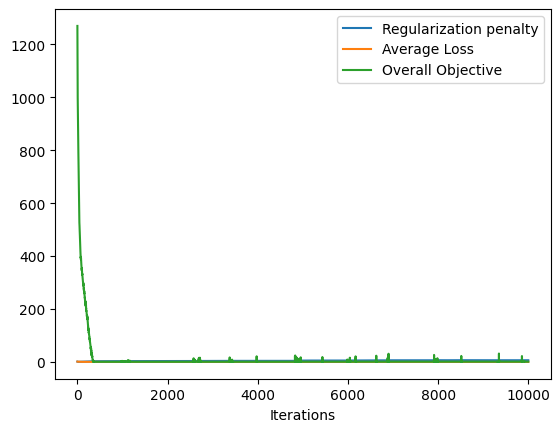

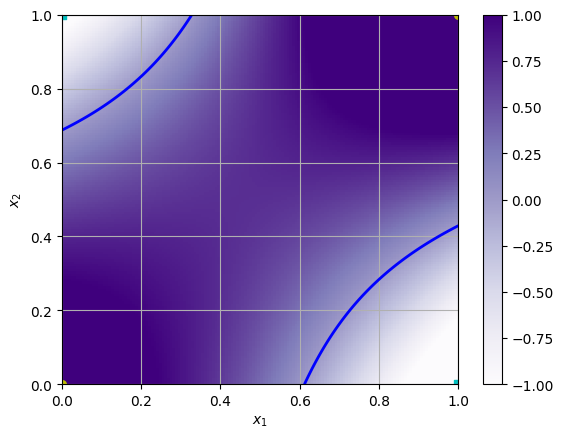

Final Objective Value 0.9399542808532715
Final weights or alphas: Parameter containing:
tensor([[-1.4952,  1.0076,  1.0254, -0.5542],
        [ 1.3852, -0.9121, -0.9838,  0.5421]], requires_grad=True)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 24 01:56:39 2023
A (for demonstration only) implementatin of both linear (weight-based) and kernelized multi-output SVM in PyTorch
Inspired from: https://gist.github.com/mlaves/c98cd4e6bcb9dbd4d0c03b34bacb0f65
@author: Fayyaz Minhas
"""

#%% Just some visualization functions (you can ignore)

import numpy as np
from sklearn.svm import LinearSVC as Classifier
import numpy as np
import matplotlib.pyplot as plt
import itertools
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:
            conts = sorted([-1+eps,0,1-eps])

    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)

        z = np.reshape(z,(npts,npts)).T


        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)

    if Y is not None:
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)

    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    if not hold:
        plt.grid()
        plt.show()
    return extent

#%% Importing torch and setting up functions for GPU access and transfer

import torch
USE_CUDA =  torch.cuda.is_available() #can enable GPU execution
from torch.autograd import Variable
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

print('Using CUDA:',USE_CUDA)

#%% This is the implementation of Both Linear (weight based) and Kernelized SVM
def hinge_loss(z, y): #implements (1/N)*sum_{i=1}^N max(0,1-y_i*x_i)
    return torch.max(torch.zeros_like(y), 1-y*z).mean()


class KernelSVM(torch.nn.Module):
    def __init__(self, train_data_x, kernel='poly', degree = 2,  gamma = 1.0, dout = 1):
        super().__init__()
        assert kernel in ['linear', 'rbf','poly','custom']
        self.dout = dout
        self._train_data_x = train_data_x #save training data
        self.kernel = kernel #kernel string
        self._n_trainable = x.size(0) #by default we set the number of trainable parameters to the number of training examples for the kernelized implementation
        self._gamma = torch.nn.Parameter(torch.FloatTensor([gamma]),
                                             requires_grad=True) #set this to true if you want to train the gamma (see poly and rbf)
        self.degree = degree #save degree of polynomial kernel
        #note both gamma and degree remain unused if kernel is 'linear'
        if kernel == 'linear':
            self._kernel = self.linear
            self._n_trainable = x.shape[1]
        elif kernel == 'poly':
            self._kernel = self.poly
        elif kernel == 'rbf':
            self._kernel = self.rbf
        elif kernel == 'custom':
            self._kernel = self.customKernel
        else: #not implemented
            assert False

        self._walpha = torch.nn.Linear(in_features=self._n_trainable, out_features=self.dout,bias = True)    #most important line
        # _walpha is a  _trainable+1 dimensional dimensional vector of trainable parameters (weights (for linear SVM) or alphas (for kernelized SVM)) and the bias term

    def customKernel(self,x):
        return x

    def poly(self,x): #implements k(xa,xb)=(gamma+xa.T*xb)^degree in vectorized code
        return (self._gamma+x@self._train_data_x.T)**self.degree
    def rbf(self, x): #implements k(xa,xb)=exp(-gamma*||xa-xb||^2) in vectorized code
        d = torch.cdist(x,self._train_data_x)
        return torch.exp(-self._gamma*d**2)
    def getTrainingKernelMatrix(self):#return NxN Kernel matrix with K_ij = k(xi,xj)
        if self.kernel == 'custom': return self._train_data_x
        if self.kernel !='linear': return self._kernel(self._train_data_x)

        return self._train_data_x@self._train_data_x.T

    def getRegularizationPenalty(self): #return regulrization penalty
        if self.kernel!='linear': #implements alphas.T*K*alphas = sum_{i=1}^N sum_{j=1}^N alpha_i * K(xi,xj) * alpha_j for kernelized SVM in vectorized code
            alphas = self._walpha.weight
            K = self.getTrainingKernelMatrix()
            reg = 0.0
            for alpha in alphas:
                reg+=alpha.T@K@alpha.T
            return reg/alphas.shape[0]
        else:
            w = self._walpha.weight.T #implements w.T*w for linear SVM
            return w.T@w

    @staticmethod
    def linear(x): #note this is not a kernel function per se
        return x

    def forward(self, x): #returns f(x) ## REPRESENTATION
        k = self._kernel(x) #for a single example x in each row: for kernelized SVM this would be k(x,:)[k(x,x_1), k(x,x_2),...,k(x,x_N)] whereas for linear SVM this would simply be x
        z = self._walpha(k) #for linear SVM this would be f(x) = w.T@x+b whereas for kernelized SVM this would be f(x) = b+alphas.T*k(x,:) = b + sum_{i=1}^N alpha_i * k(x,x_i)
        return z #return f(x)


if __name__=='__main__':
    #loading data
    #x0 = np.array([[0,0],[0,1],[1,0],[1,1]]);     y0 = np.array([-1,-1,-1,1]) #AND
    x0 = np.array([[0,0],[0,1],[1,0],[1,1]]);     y0 = np.array([[-1,1,1,-1],[1,-1,-1,1]]).T #XOR
    #from sklearn.datasets import make_moons;    x0, y0 = make_moons(20, noise=0.1);     y0[np.where(y0==0)] = -1; y0 = np.atleast_2d(y0).T #Moons
    #portint data torch
    x = toTensor(x0)
    y = toTensor(y0)
    #creating SVM
    x = (x@x.T+1)**3
    model = KernelSVM(x,kernel='custom',dout = y.shape[1])#,degree = 4, gamma = 1)
    model=cuda(model)
    C = 1000 #C Hyperparameter in SVM formulation
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #optimizer stochastic gradient descent (however because we are not picking examples randomly this is gradient descent)
    History = [] #Just for plotting the convergences
    for i in range(10000):        #1000 iterations should be good enough

        z = model(x) #calculate f(x) #Representation

        avg_loss = hinge_loss(z, y) #calculate error #Evaluation
        reg_penalty = model.getRegularizationPenalty() #calculate penalty term for regularization
        objective = 0.15*reg_penalty+C*avg_loss #Implement Structural Risk Minimization Objective for SVM

        #optimization steps that will update alpha for kernelized SVM and weighths for linear one
        History.append((reg_penalty.item(),avg_loss.item(),objective.item()))
        optimizer.zero_grad()
        objective.backward()
        optimizer.step()
    #just plotting
    #%%
    plt.figure();plt.plot(np.array(History)); plt.legend(['Regularization penalty','Average Loss','Overall Objective']);plt.xlabel('Iterations')
    plt.figure()
    plotit(x0,y0[:,-1],clf = lambda x: toNumpy(model(toTensor((x@x0.T+1)**3)))[:,-1] ,conts=[0])#,extent=[-1.5,+1.5,-1.5,+2])
    print("Final Objective Value", objective.item())
    print("Final weights or alphas:",model._walpha.weight)